# Homework 4 from Martin Gräf and Richard Baumann

In this Homework we look at the error analysis of the markov chain, that we talked about in the last homework. Therefore as a start we use the artificial hamiltonian, the equations of motion, the estimate of the magnetization, the leapfrog algorithm and the hybrid monte Carlo simulation, that were established in the last homework. Therefore the next lines are identical to the ones in the last homework.

In [1]:
import sys
import os
import io
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import math
import pandas as pd
import scipy.special as sp

In [2]:
# The artificial Hamiltonian as defined in exercise 3
def Hamiltonian(p , phi, N, beta_J, beta_h):
    return ((p*p/2)+(phi*phi/(2*(beta_J)))-N*np.log(2*np.cosh(phi+beta_h)))

In [3]:
# Here could also be a parameter called trajLength, but on the exercise sheet
# it was given that this is supposed to be 1.
def leapfrog(p_start, phi_start, Nmd, N, beta_J, beta_h):
    p_end = p_start
    phi_end = phi_start
    
    # epsilon = trajLength/Nmd
    epsilon = 1/Nmd
    
    # first half step of the leap frog
    phi_end = phi_end + (epsilon/2) * p_end
    
    # Now do all the steps untill the last one:
    for i in range((Nmd)-1):
        p_end = p_end + epsilon* (-(phi_end/(beta_J))+(N*np.tanh(phi_end+beta_h)))
        phi_end = phi_end + epsilon * p_end
        
    # last half step
    p_end = p_end + epsilon * (-(phi_end/(beta_J))+(N*np.tanh(phi_end+beta_h)))
    phi_end = phi_end + (epsilon/2) * p_end
    
    return (p_end, phi_end)

In [4]:
def hybrid_mc(N, J, h, nmd, nTrajs):

    magnetization=[]

    Jhat=J/N
    
    phi=0
    
    for traj in range(nTrajs):
        # generate a random value for p
        pi = np.random.normal(0, 1)

        # And calculate the starting energy
        H_start=Hamiltonian(pi, phi, N, Jhat, h)

        # Do a leapfrog estimation of the evolved variables
        pi_f, phi_f=leapfrog(pi, phi, nmd, N, Jhat, h)

        # Calculate the energy afterwards
        H_final = Hamiltonian(pi_f, phi_f, N, Jhat, h)

        # Metropolis hastings steps. Accept if condition below is met
        if np.random.uniform(0, 1) <= np.exp(-(H_final-H_start)):
            # Update phi
            phi=phi_f
        
        #put the new phi into the magnetization array
        magnetization.append(np.tanh(h+phi))
    
    # return that array
    return (np.array(magnetization))

## 1: Plot the first couple hundred trajectories of the MC history of {m}. How do the trajectories differ for the two MCs?

Now that we have carried over the functions form the last exercise sheet, we can start generating markov chains. The parameters, given on the exercise sheet, that should be used to generate said chains are:

* βJ = 0.1; βh = 0.5; n = 5; Nmd = 100
* βJ = 0.1; βh = 0.5; n = 5; Nmd = 4

The magnetization of the first hundred trajectories of these parameters can be seen in the diagram below:

Array 1: 0.49290699450815406 Array 2: 0.5026345001425727


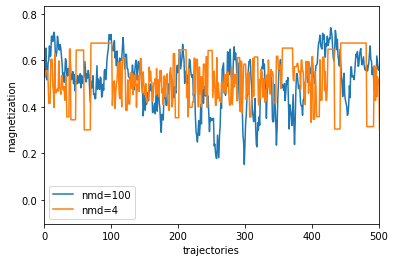

In [5]:
# Generate magnetization arrays with the given parameters, deleting thermalization (first 4000 entries) 
phi_array_1 = np.delete(hybrid_mc( 5, 0.1, 0.5, 100, 12800),np.arange(4000))
phi_array_2 = np.delete(hybrid_mc( 5, 0.1, 0.5, 4, 12800),np.arange(4000))


# Plotting said values
plt.plot(phi_array_1, label="nmd=100")
plt.plot(phi_array_2, label="nmd=4")
plt.legend(loc="best")
plt.xlabel("trajectories")
plt.ylabel("magnetization")
plt.xlim(0, 500)
plt.savefig("pictures/magnetization.png", dpi=600)

# Average of the values (for comparison)
print("Array 1:", np.average(phi_array_1), "Array 2:", np.average(phi_array_2))

We can see, that the values seem to be correct. Both have a mean that is close to 0.49, which was given as the correct mean on the exercise sheet. 
### The trajectory of the HMC data, that was created using nmd=4 seems show less fluctuations, but there are some areas where the generated angle does not change, so the accept reject step was not successfull. 


After calculating these magnetizations, we want to estimate the errors, that emerge from this estimate. We take a look at the corrolation of our data, since we no longer have independend data but data that is dependend on the previous step. A unsefull quantity in order to analyze autocorrolations is the autocorrolation function, which is defined as:

\begin{equation}
\Gamma^{(m)}(|k-l|)=<(m(\Phi_k)-<m>)><(m(\Phi_l)-<m>)>
\end{equation}

The autocorrolation function can be implemented with:

\begin{equation}
    \bar{\Gamma}^{(m)} (\tau)= \frac{1}{\#(k, l)} \sum_{(k, l):\tau=|k-l|} (m_k-\bar{m}_N)(m_l-\bar{m}_N)
\end{equation}

A better visualization for the algorithm is given by:

\begin{equation}
    \bar{\Gamma}^{(m)} (\tau)= \frac{1}{N-\tau} \sum_{i=1}^{N-t} (m_i-\bar{m})(m_{i+\tau}-\bar{m})
\end{equation}

An estimator for the normalized autocorrolationc is defined as:

\begin{equation}
c(\tau)= \frac{\bar{\Gamma}^{(m)} (\tau)}{\bar{\Gamma}^{(m)} (0)}
\end{equation}

In [6]:
# Implementation of the Gamma function above
def autocorrolation_function(array, tau, mean):
    sum = 0

    # Summing the individual terms
    for i in range(len(array)-tau):
        sum += (array[i]-mean)*(array[i+tau]-mean)
        
    return (sum/(len(array)-tau))

# Estimating the autocorrolation for tau (gamma(tau)/gamma(0))
def autocorrolation_estimator(array, tau, mean):
    return (autocorrolation_function(array, tau, mean)/autocorrolation_function(array, 0, mean))

## 2: Implement the straightforward estimator C($\tau$) for the normalized autocorrelation function and plot the function of C($\tau$) for your generated data sets.

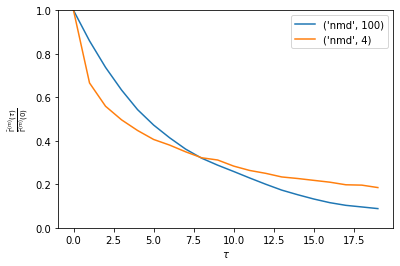

In [7]:
def test_autocorrolation(phi_array, nmd):
    tau_max=20

    # Initilizing the array for the Values of the estimator
    c_array=np.zeros(tau_max)

    # Calculating the mean value for the magnetization arrays 
    # (because we don`t want to calculate that term a lot of times
    # in the function)
    mean_array=np.average(phi_array)

    # Calculating the estimator values for tau \in [0, 15]
    for i in range(0, tau_max):
        c_array[i]=autocorrolation_estimator(phi_array, i, mean_array)
    # Plotting these values
    plt.plot(c_array, label=("nmd", nmd))

# Testing out the autocorrolation of the first and second
# array by plotting it.
test_autocorrolation(phi_array_1, 100)
test_autocorrolation(phi_array_2, 4)
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\frac{\bar{\Gamma}^{(m)} (\tau)}{\bar{\Gamma}^{(m)} (0)}$")
plt.ylim(0, 1)
plt.legend(loc="best")
plt.savefig("pictures/autocorrolation.png", dpi=600)

We can see, that a significant margin of autocorrolation is present. This is what we would expect given that our leapfrog method uses a current value to calculate the next one. Both curves show a similar expected behaviour: Large Autocorrolations that decrease over time. Therefore the dependency between one value and a more distant one is lower. 

The curve for a lower ammount of nmd falls of quicker but both curves converge towards a similar point. Upon multiple different generated data stets one can see, that the behaviour of the orange curve seems to fluctuate more than the blue curve.

One way to reduce autocorrolations is to block or bin data. That can reduce the neagitve effects of autocorrolation. For that we block every b neighbouring values together, creating blocks of b values. Every block is then averaged, so that we get a smaller array than before. Taking the average of this values gives us a magnetization, that should be less autocorrolated.

In [8]:
# Bin the original data
def binning(array, b):

    binned_array = []

    # We split the array into len(array)/b big blocks
    array=np.split(array, len(array)/b)

    # And each of the blocks is averaged
    for i in range(len(array)):
        binned_array.append(np.average(array[i]))

    # Now we have an array, that is binned
    return (np.array(binned_array))

## 3: Generate blocked data for b =2, 4, 8, 16, 32, and 64, and calculate the autocorrelation for each blocked list. Does it behave the way you expect? With the blocked lists, estimate the naive standard error with $\frac{\sigma}{\sqrt{(N/b)}}$ and observe the behavior, where $ \sigma $ is the standard deviation of the blocked list.

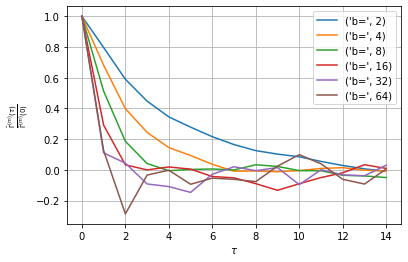

In [9]:
# This function plots the autocorrolation and gets the std for every binned array
def plot_bin_autocorrolation_dependency(data_array, tau_max): #b_min, b_max,
    # Initilization of arrays for later saving
    c_array=np.zeros(tau_max)
    std_array=np.zeros(6)

    # loop over all b values (2, 4, 8, 16, 32, 64)
    for b in [2, 4, 8, 16, 32, 64]:

        # binn the array for the respective b
        binned_array=binning(data_array, b)

        # Calculate the autocorrolation for the binned array
        #   tau here goes from 0 to tau max (15, because that is the point
        #   where in the picture above nothing changed.)
        for i in range(tau_max):
            c_array[i]=autocorrolation_estimator(binned_array, i, np.average(binned_array))

        # Plot the autocorrolation of the first b-array
        plt.plot(c_array, label=("b=", b))

        # Calculate the std b-array with the naive estimation 
        # \sigma over \sqrt{(N/b)}
        # We append that to an array to compare it later on
        std_array_naive.append(round(np.std(binned_array)/((len(data_array)/b)**(1/2)), 6))
    plt.legend(loc="best")
    plt.grid()

    # return the std so that it can be saved
    return (std_array_naive)

# Generate and store the std. of the naive approaches
std_array_naive=[]
std_array_naive=(plot_bin_autocorrolation_dependency(phi_array_1, 15))
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\frac{\bar{\Gamma}^{(m)} (\tau)}{\bar{\Gamma}^{(m)} (0)}$")
plt.savefig("pictures/binned_autocorrolation_phi1.png", dpi=600)

### Does it behave the way you expect?

This curve looks excatly as the curve that we have seen in lecture 4, where an example for binning was introduced. In this lecture it was stated that bigger blocks reduce autocorrolation at a higher std. The value of the std should asymptot towards a realistic value. We can also see that behaviour. The behaviour is discusse more later on.

Now we can implement the bootstrap method to estimate the error of our magnetization. The bootstrap method for a N-long list works in this way:

* Create an array, that is also N long
* Fill this array with N random elements from the original list
* Save the mean of the array
* Repeat this process $N_{bs}$ - times

After that we should have an array filled with $N_{bs}$ means. The bootstrap error can be calulated by taking the std. of this $N_{bs}$-long mean array. 

## 4: Code up the bootstrap procedure and calculate the bootstrap error for your blocked list of {m}. Investigate the stability of the error as a function of $N_{bs}$. How does the bootstrap error compare with your naive estimate from above?

In [10]:
def bootstrap_error(m_array, nBS):  

    # Here we will later on store the mean
    # values of the bootstrap sample
    bsmean = np.array([])

    # For the number of bootstrap samples, we:
    for bs in range (nBS):

        # Generate an array index. This array is full of numbers between 0 and len(m_array)
        # These are our random bootstap indicies
        index=np.random.randint(m_array.size,size=m_array.size)

        # Now we do a lot of stuff at once, but:
        #   We create an array. Now we go through every index in our 
        #   index array, that we created before. Corresponding to the integer in index the 
        #   index-th entry of m_array is added to our created array. We then take the main 
        #   of this array and add it to our array called bsmean.
        bsmean = np.append(bsmean,np.array([m_array[index[i]] for i in range(m_array.size)]).mean())
    
    # The error, that is estimated by bootstrap is the std of our bsmean array.
    return bsmean.std()

Now we can look at the stability of the error as a function of $ N_{bs} $. For that we just calculate some samples of an error estimation with different values for $ N_{bs} $.

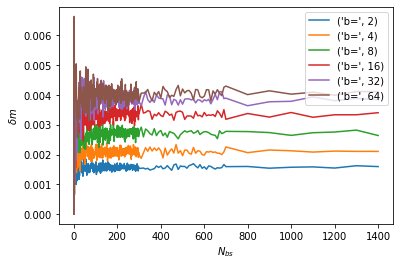

<Figure size 720x720 with 0 Axes>

In [11]:
def stability(array, b):

    # Initilizing different numbers for the ammount of bootstrap samples
    nBs_array=np.append(np.arange(1, 300, 1), np.arange(301, 700, 10))
    nBs_array=np.append(nBs_array, np.arange(700, 1500, 100))

    # Initilizing an empty array for the errors that we will estimate using bootstrap
    error_array=np.zeros(len(nBs_array))

    for i in range(len(error_array)):
        # The bootstrap error is estimated using the first splitted 
        # array and different numbers of bootstrap samples
        error_array[i]=bootstrap_error(binning(array, b), nBs_array[i])

    # Here we are plotting the dependency of estimate of the error 
    # on the ammount of bootstrap samples 
    plt.plot(nBs_array, error_array, label=("b=", b))

# For b= 2, 4, 8, 16, 31, 64 estimate bootstrap error
for b in [2, 4, 8, 16, 32, 64]: # 
    stability(phi_array_1, b)
    plt.legend(loc="best")
plt.xlabel(r"$N_{bs}$")
plt.ylabel(r"$\delta m$")
plt.figure(figsize=(10, 10))
plt.savefig("pictures/stability.png", dpi=600)
    

In the diagramm above we tried to investigate a wide range of values for $N_{bs}$. We saw, that for small $N_{bs}$ there is a large fluctuation, so we tried out $N_{bs}$ $\in$ [1, 300] in steps of one. 

After that it is pretty much safe to say, that the big fluctuations stop and only small fluctuations survive. Because of that we increased the size of the increments to 10 for $N_{bs} \in$ [301, 700]. 

The fluctuations don`t seem to become much smaller, but just to be safe we also looked at the area $N_{bs} \in$ [700, 1500] where we see no notable change. Therefore we assume, that these fluctuations are normal and we choose a $N_{bs}$ of 1000 for all measurements below.

WE did not go higher, since this is already pretty recource intensive and the trends in the curves did not indicate significant improvements

In [14]:

# make an array for the stds of the bootstrap method.
std_array_bs=[]

for b in [2, 4, 8, 16, 32, 64]:
    #print("std at b =", b, round(bootstrap_error(binning(phi_array_1, b), 500), 6))
    std_array_bs.append(round(bootstrap_error(binning(phi_array_1, b), 1000), 6))

In [17]:
# Here we create a pandas Data frame to make the data more readable
data = np.array([np.full(6, np.average(phi_array_1)), std_array_bs, std_array_naive])
df = pd.DataFrame(data=data)
df = df.transpose()
df.columns=["Average magnetization", "Std. from using bootstrap", "Std. from using naive approach"]
df["difference"]=abs(df["Std. from using bootstrap"] - df["Std. from using naive approach"])
print(df)

   Average magnetization  Std. from using bootstrap  \
0               0.492907                   0.001608   
1               0.492907                   0.002074   
2               0.492907                   0.002764   
3               0.492907                   0.003246   
4               0.492907                   0.003941   
5               0.492907                   0.004088   

   Std. from using naive approach  difference  
0                        0.001571    0.000037  
1                        0.002098    0.000024  
2                        0.002720    0.000044  
3                        0.003354    0.000108  
4                        0.003840    0.000101  
5                        0.004020    0.000068  


Interestingly enough, the errors do not seem to differ a lot. The difference between both error estimations are fluctuant but in the range of 0.0001 which is one magnitude smaller then the original value. Therefore the naive estimate seems to be pretty accurate. 

Both error estimations go up, the larger the size of the blocks become. This is also backed by what we learned in the lecture. Both estimates go against a more realistic value the larger the binned blocks are. 